In [1]:
from netCDF4 import Dataset
from datetime import timedelta, datetime
from collections import OrderedDict
import pandas as pd
import altair as alt

In [2]:
def read_series_from_netcdf(nc_path, location, quantity):
    """ function to read timeseries from SOBEK netcdf
    """
    nc_file = Dataset(nc_path)
    nc_location_var = nc_file.variables["observation_id"]
    location_lst = [b''.join(x).strip() for x in nc_location_var[:]]

    gridpoint_index = location_lst.index(location)

    nc_quantity_var =  nc_file.variables[quantity]
    values = nc_quantity_var[:,gridpoint_index]
    times = nc_file.variables["time"][:]
    units = nc_file.variables["time"].units

    start_date = datetime.strptime(units.strip('seconds since '), "%Y-%m-%d %H:%M:%S")

    time_series = OrderedDict()
    for t, v in zip(times, values):
        if isinstance(t, (int, float)):
            t_dt = start_date + timedelta(seconds=t)
        elif isinstance(t, datetime):
            t_dt = t
        else:
            print("Got type %s for date, while int, float or datetime was expected", type(t))
        t_str = datetime.strftime(t_dt, "%Y-%m-%d %H:%M:%S")
        time_series[t_str] = v

    df = pd.Series(time_series).to_frame()
    df.columns=["{}".format(location.decode("utf-8"))]

    return df

In [3]:
def get_observations_overview(obs_path, csv_path, location_up, location_do, quantity):
    """ combine netcdf with status csv file
    """
    # read up- and downstream location MK
    df_up = read_series_from_netcdf(obs_path, location_up, quantity)
    df_do = read_series_from_netcdf(obs_path, location_do, quantity)    

    # combine up- and downstream location
    df = pd.concat((df_do, df_up), axis=1)
    df.index = pd.to_datetime(df.index)   
    
    # read BOS status MK
    df_csv = pd.read_csv(csv_path)   
    
    # parse datetime and get unique states as list
    df_csv.index = pd.to_datetime(df_csv.date)
    states = df_csv.state.unique().tolist()
    #df_csv.head()    
    
    # merge states with waterlevel and forward fill status
    df_merge = pd.merge(df, df_csv, how='outer', left_index=True, right_index=True)
    df_merge.reset_index(inplace=True)
    cols = ['date', 'state', 'comp1', 'comp2']
    df_merge[cols] = df_merge[cols].ffill()
    #df_merge.head()

    # prepare for water level locations
    df_melt = df_merge.melt(id_vars=['index', 'state', 'comp1', 'comp2'], value_vars=['Nieuwe Waterweg Maeslantkering zee', 'Nieuwe Maas Maeslantkering rivier'], var_name='location')  
    
    return df_melt, states

In [4]:
# observations netcdf
obs_path_f0 = r"D:\Projects\Pr\MHWp5\Toeleveringen\MHWp5\results\q3_h5_u5_d1_failure_0\model_output\dflow1d\output\observations.nc"
obs_path_f3 = r"D:\Projects\Pr\MHWp5\Toeleveringen\MHWp5\results\q3_h5_u5_d1_failure3_v2\model_output\dflow1d\output\observations.nc"
# barrier csv
csv_path_f0 = r"D:\Projects\Pr\MHWp5\Toeleveringen\MHWp5\results\q3_h5_u5_d1_failure_0\model_output\dflow1d\output\Maeslantkering_overview.csv"
csv_path_f3 = r"D:\Projects\Pr\MHWp5\Toeleveringen\MHWp5\results\q3_h5_u5_d1_failure3_v2\model_output\dflow1d\output\Maeslantkering_overview.csv"

# location and quantity of interest
location_up = b"Nieuwe Maas Maeslantkering rivier"
location_do = b"Nieuwe Waterweg Maeslantkering zee"
quantity = "water_level"

In [5]:
df_melt_f0, states_f0 = get_observations_overview(obs_path_f0, csv_path_f0, location_up, location_do, quantity)
df_melt_f3, states_f3 = get_observations_overview(obs_path_f3, csv_path_f3, location_up, location_do, quantity)

In [14]:
# chart failure 0
zoom_left = alt.selection_interval(bind='scales', encodings=['x'])

top_left = alt.Chart(df_melt_f0).mark_line().encode(
  x = alt.X('index:T', timeUnit = 'yearmonthdatehoursminutes', title = None),
  y = alt.Y('value:Q', title = 'waterlevel [m+NAP]', scale=alt.Scale(domain=[-1,5.5])),
  color = alt.Color('location:N'),
  tooltip = [alt.Tooltip('value:Q', format = '.2f'),'state:O', alt.Tooltip('index:T', format = '%Y-%m-%d %H:%M')]
).add_selection(zoom_left)

bottom_left = alt.Chart(df_melt_f0).mark_line().encode(
  x = alt.X('index:T', timeUnit = 'yearmonthdatehoursminutes', title = None),
  y = alt.Y('state:O', sort = states_f0[::-1]),
  order = alt.Order('index:T'),
  tooltip = ['state:O', 'comp1:O', 'comp2:O', alt.Tooltip('index:T', format = '%Y-%m-%d %H:%M')]
).add_selection(zoom_left)

panel_left = (top_left & bottom_left).properties(title = 'Q3_H5_U5_D1 Normaal functioneren')

In [23]:
# chart failure 3
zoom_right = alt.selection_interval(bind='scales', encodings=['x'])

top_right = alt.Chart(df_melt_f3).mark_line().encode(
    x=alt.X('index:T',timeUnit='yearmonthdatehoursminutes', title=None),
    y=alt.Y('value:Q', title='waterlevel [m+NAP]', scale=alt.Scale(domain=[-1,5.5])),
    color=alt.Color('location:N'),
    tooltip = [alt.Tooltip('value:Q', format = '.2f'),'state:O', alt.Tooltip('index:T', format = '%Y-%m-%d %H:%M')]
).add_selection(zoom_right)

bottom_right = alt.Chart(df_melt_f3).mark_line().encode(
    x=alt.X('index:T',timeUnit='yearmonthdatehoursminutes', title=None),
    y=alt.Y('state:O', sort = states_f0[::-1]),#sort=states_f3[::-1]),
    order=alt.Order('index:T'),
    tooltip=['state:O', 'comp1:O', 'comp2:O',alt.Tooltip('index:T', format='%Y-%m-%d %H:%M')]                 
).add_selection(zoom_right)

panel_right = (top_right & bottom_right).properties(title = 'Q3_H5_U5_D1 Faalmodus - 2')

In [24]:
chart = (panel_left | panel_right).configure_legend(labelLimit = 0).configure_axisY(grid=True)

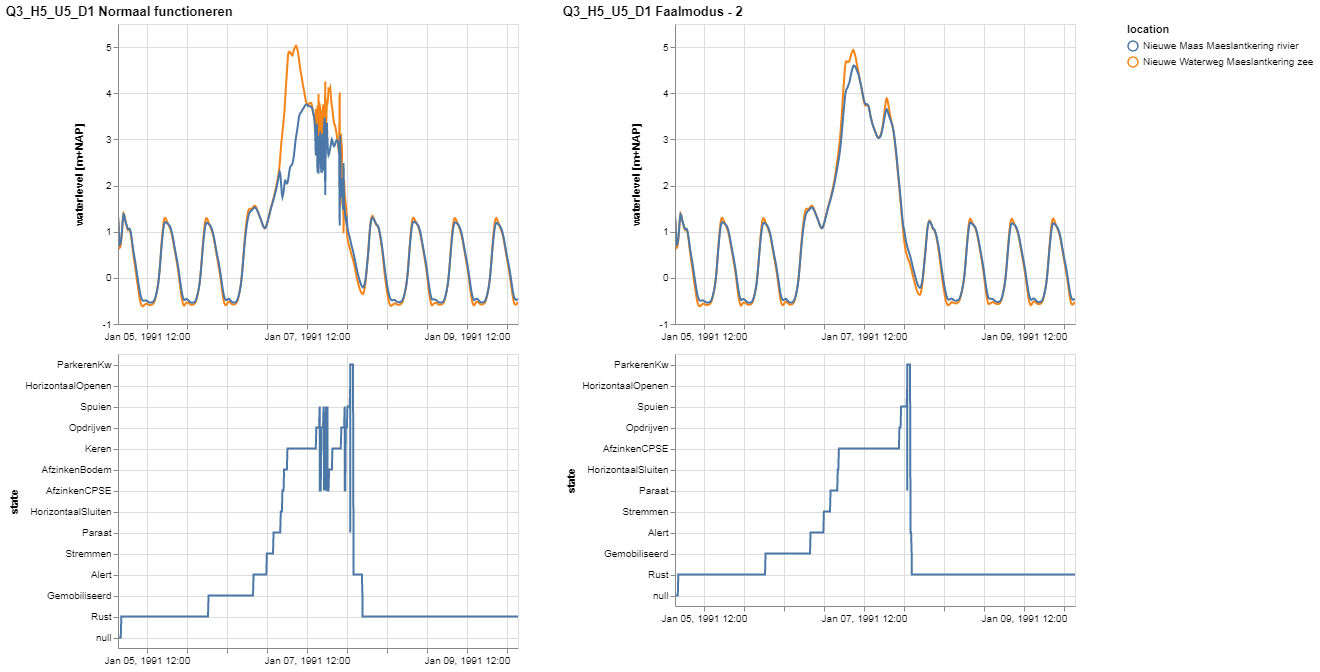

In [25]:
# render in notebook
chart

In [26]:
# save as png and html
chart.save('Q3_H5_U5_D1 Normaal functioneren en faalmodus-2.png', scale_factor=4.0)
chart.save('Q3_H5_U5_D1 Normaal functioneren en faalmodus-2.html')